In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
fdir = "D:\\crs\\proj\\2017_Ontario\\2017-07-12_Lake_Bluffs_v3\\"
fname = ("2017-07-12_Lake_Bluff_Crescent_Bar_DEM_5cm.tif")

# read DEM channel 1
with rasterio.open(fdir+fname) as dem:
    z = dem.read(1)
    
print(np.shape(z))


(23600, 33980)


In [2]:
# coordinate reference system
print(dem.crs)
# data transform
print(dem.transform)
# upper left corner
print('upper left: ',dem.transform*(0,0))
# lower right corner
print('lower right: ',dem.transform*(dem.width, dem.height))

# find the array index of a point by inverting the transform (!)
# note order: (easting, northing)
print( ~dem.transform*(341294.0, 4793569.0) )

CRS({'init': 'epsg:26918'})
| 0.05, 0.00, 341294.00|
| 0.00,-0.05, 4793569.00|
| 0.00, 0.00, 1.00|
upper left:  (341294.0, 4793569.0)
lower right:  (342993.0, 4792389.0)
(0.0, 0.0)


In [10]:
# read in the transect points
tfname = '2017-07-12-13_Crescent_Bar_Lake_Bluffs_trans.txt'
column_names = ['id','n','e','elev','lat','lon','label']
import pandas as pd
df=pd.read_csv(fdir+tfname,header = None, names = column_names)
print(df)
print("Read: ",len(df.index),' lines.')

      id             n            e      elev        lat        lon     label
0     11  4.793302e+06  342642.8825  101.9704  43.276098 -76.939247    BLUFF1
1     12  4.793294e+06  342644.3948  102.1922  43.276029 -76.939226    BLUFF2
2     13  4.793292e+06  342631.5170  104.3634  43.276012 -76.939384    BLUFF3
3     14  4.793293e+06  342620.3511  104.9136  43.276020 -76.939522    BLUFF5
4     15  4.793277e+06  342628.2735  104.6322  43.275870 -76.939420    BLUFF6
5     16  4.793272e+06  342609.1304  105.3865  43.275822 -76.939654    BLUFF7
6     17  4.793255e+06  342608.0334  105.9512  43.275673 -76.939663    BLUFF8
7     18  4.793232e+06  342607.9388  106.1509  43.275462 -76.939658    BLUFF9
8     19  4.793233e+06  342598.2427  106.3250  43.275472 -76.939777   BLUFF10
9     20  4.793238e+06  342585.8629  106.0753  43.275516 -76.939931   BLUFF11
10    21  4.793230e+06  342578.3045  106.0633  43.275437 -76.940022   BLUFF12
11    22  4.793211e+06  342585.1251  106.7299  43.275270 -76.939

In [4]:
# TODO - add a bilinear interpolation scheme.
def bilint(z,en):
    """
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    #print(r,ir,rx,'  ',c,ic,cy)
    #print(z[ir,ic],z[ir+1,ic])
    #print(z[ir+1,ic],z[ir+1,ic+1])
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi

In [11]:
# arrays for DEM and differences calcs
zdem = np.NaN*np.ones(len(df.index))
zdem_minus_meas = np.NaN*np.ones(len(df.index))
zdi = np.NaN*np.ones(len(df.index))
zdemi_minus_meas = np.NaN*np.ones(len(df.index))

for index, row in df.iterrows():
    # print(row["n"], row["e"])
    en = ~dem.transform*(row["e"],row["n"])
    # print( index, en )
    
    # this returns the z value of the 
    try:
        zdem[index] = z[np.int(en[1]),np.int(en[0])]
    except:
        print("out of bounds for", index, em)
    
    # this one does bilinear interpolation
    try:
        zdi[index]=bilint(z,en)
    except:
        print("interpolation problem")
    
    # No data values for DEM are -32767
    if(zdem[index]<-32766.):
        zdem[index]=np.NaN
        zdi[index]=np.NaN
    
    zdemi_minus_meas[index] = zdi[index]-row["elev"]
    zdem_minus_meas[index] = zdem[index]-row["elev"]
    #print( zdem[index], zdi[index], row["elev"], zdem_minus_meas[index]  )

In [ ]:
# add columns to the dataframe
#df.assign(DEM2=pd.Series(zdem,index=df.index))
df['DEM corner']=pd.Series(zdem,index=df.index)
df['DEM int']=pd.Series(zdi,index=df.index)
df['DEM_minus_trans']=pd.Series(zdem_minus_meas,index=df.index)
df['DEMi_minus_trans']=pd.Series(zdemi_minus_meas,index=df.index)

In [13]:
df.to_csv('Lake_Bluff_DEM_minus_trans.csv',na_rep='-32767',sep=',',float_format='% 12.4f')
df

,id,n,e,elev,lat,lon,label,DEM corner,DEM int,DEM_minus_trans,DEMi_minus_trans
0,11,4.793302e+06,342642.8825,101.9704,43.276098,-76.939247,BLUFF1,101.991005,101.992057,0.020605,0.021657
1,12,4.793294e+06,342644.3948,102.1922,43.276029,-76.939226,BLUFF2,102.234154,102.230633,0.041954,0.038433
2,13,4.793292e+06,342631.5170,104.3634,43.276012,-76.939384,BLUFF3,104.365585,104.365760,0.002185,0.002360
3,14,4.793293e+06,342620.3511,104.9136,43.276020,-76.939522,BLUFF5,104.899109,104.899317,-0.014491,-0.014283
4,15,4.793277e+06,342628.2735,104.6322,43.275870,-76.939420,BLUFF6,104.626335,104.630265,-0.005865,-0.001935
5,16,4.793272e+06,342609.1304,105.3865,43.275822,-76.939654,BLUFF7,105.410202,105.409545,0.023702,0.023045
6,17,4.793255e+06,342608.0334,105.9512,43.275673,-76.939663,BLUFF8,105.983421,105.982856,0.032221,0.031656
7,18,4.793232e+06,342607.9388,106.1509,43.275462,-76.939658,BLUFF9,106.200409,106.200421,0.049509,0.049521
8,19,4.793233e+06,342598.2427,106.3250,43.275472,-76.939777,BLUFF10,106.342674,106.340766,0.017674,0.015766
9,20,4.793238e+06,342585.8629,106.0753,43.275516,-76.939931,BLUFF11,106.098907,106.094502,0.023607,0.019202


count    94.000000
mean      1.143418
std       5.038250
min     -11.292939
25%      -0.012032
50%       0.046729
75%       0.342850
max      22.802696
Name: DEMi_minus_trans, dtype: float64

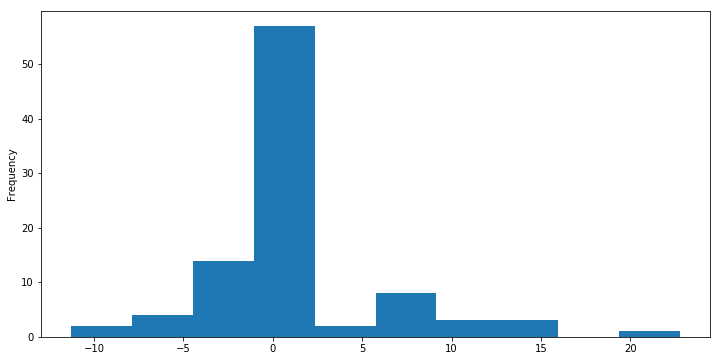

In [14]:
plt.figure(figsize=(12,6))
df['DEM_minus_trans'].plot(kind='hist')
df['DEM_minus_trans'].describe()
df['DEMi_minus_trans'].describe()

In [ ]:
plt.plot(figsize=(12,6));plt.imshow(z[::],cmap=plt.cm.terrain,vmin=75,vmax=130)